In [1]:
#importing modules
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pickle
import tqdm
import time
import math

from keras.models import Sequential
from keras.layers import Dense
import keras
from IPython.display import clear_output

from random import choice

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.semilogy(self.x, self.losses, label="loss")
        plt.semilogy(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [2]:
f = h5py.File('second_sample.hdf5','r')

print(f.keys())
print(f['data'].attrs.keys())
print(f['data'].attrs['title'])
print(f['data'].attrs['descr'])
print(f['data'].attrs['columns'])

rawdata = np.copy(f['data'])
f.close()

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['N', 'columns', 'descr', 'title']>
First fake dataset
Here is where we can leave notes on how we made the data set...
0-2047: wavenumber, 2048-4095: flux, z, Nar_fwhm, BLR_fwhm, BLR_fl,Nar_fl,NII_fl,Cont,Type


In [3]:
rawdata.shape

(100000, 4104)

In [4]:
freq =   rawdata[:,   0:2048]
flux =   rawdata[:,2048:4096]
opzs = 1+rawdata[:,4096]

In [5]:
### Define function that turns the edges of the wavelengths and 
### number of samples and position into (1+z) under the assumption it was HII

def con_pos2opz(index, leftedge,rightedge,num):
    return (index/num*(rightedge-leftedge)+leftedge)/(6562.8/1e4)

def con_opz2pos(opz, leftedge,rightedge,num):
    return (opz*(6562.8/1e4)-leftedge)/(rightedge-leftedge)*num



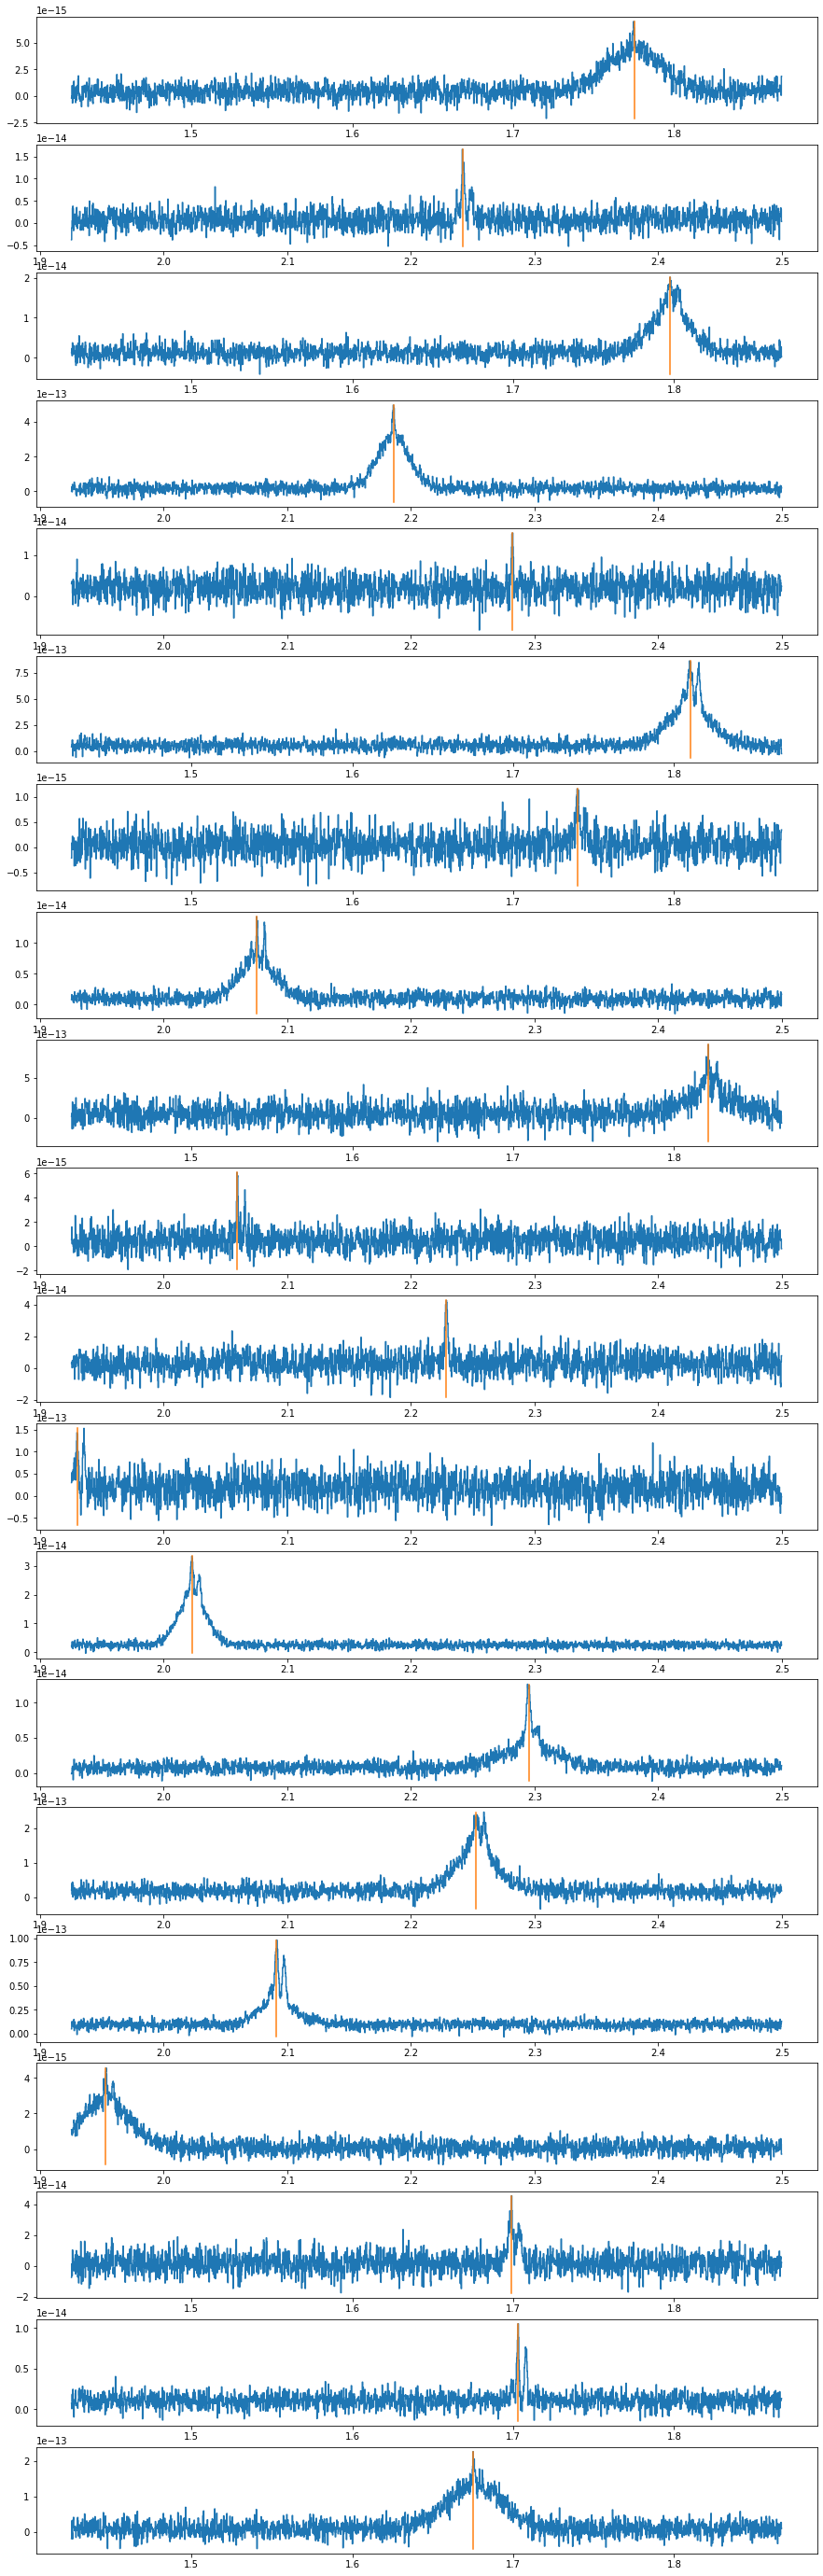

In [6]:
toshow = 1
offset = 0
plt.figure(figsize=(15,2.5*toshow))
for i in range(offset,offset+toshow):
    plt.subplot(toshow,1,i+1-offset)
    plt.plot(freq[i],flux[i],drawstyle='steps-mid')
    guess = int(con_opz2pos(opzs[i],freq[i,0],freq[i,-1],2048))
    plt.plot([freq[i,guess],freq[i,guess]],[np.min(flux[i]),np.max(flux[i])])
plt.show()

## First make a rough guess on z by looking for the maximum and then bind a window around it.

### First check this is not too wrong

In [7]:
## I am going to soften the flux, that way I can remove the spurious maxima

softflux7 = np.zeros_like(flux)
softflux3 = np.zeros_like(flux)

for i in tqdm.tqdm(range(len(flux))):
    softflux7[i] = np.convolve(flux[i],np.ones(7)/7,'same')
    softflux3[i] = np.convolve(flux[i],np.ones(3)/3,'same')

100%|██████████| 100000/100000 [00:04<00:00, 22468.72it/s]


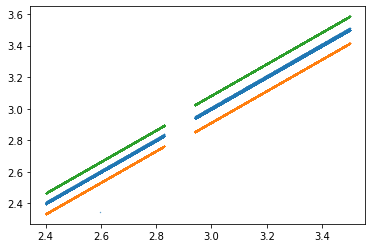

In [8]:
opz_guess3 = con_pos2opz(np.argmax(softflux3,axis=1),freq[:,0],freq[:,-1],2048)
opz_guess7 = con_pos2opz(np.argmax(softflux7,axis=1),freq[:,0],freq[:,-1],2048)

## These show the window that of 200 pixels in each direction...
opz_guess_l = con_pos2opz(con_opz2pos(opzs,freq[:,0],freq[:,-1],2048)-200,freq[:,0],freq[:,-1],2048)
opz_guess_h = con_pos2opz(con_opz2pos(opzs,freq[:,0],freq[:,-1],2048)+200,freq[:,0],freq[:,-1],2048)

plt.scatter(opzs,opz_guess3,s=0.1)
plt.scatter(opzs,opz_guess_l,s=0.01)
plt.scatter(opzs,opz_guess_h,s=0.01)
#plt.scatter(opzs,opz_guess_h,s=0.1)

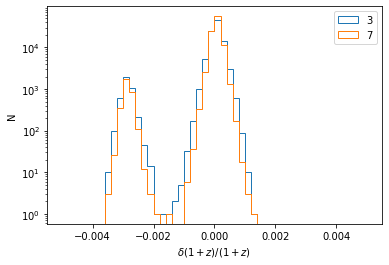

99999.0
100000.0


In [9]:
## Another way to see this:

k3 = plt.hist((opzs-opz_guess3)/opzs,bins=np.linspace(-.005,.005,51),histtype='step',label='3')
k5 = plt.hist((opzs-opz_guess7)/opzs,bins=np.linspace(-.005,.005,51),histtype='step',label='7')
plt.legend()
plt.yscale('log')
plt.ylabel('N')
plt.xlabel(r'$\delta (1+z)/(1+z)$')
plt.show()
print(np.sum(k3[0]))
print(np.sum(k5[0]))

## Now that we have a good rough knowledge of z, we can choose a window. And rescale...

In [10]:
nconvert = len(rawdata)
#nconvert = 20
window = 200
wfreq = np.zeros((nconvert,int(2*window+1)))
wflux = np.zeros((nconvert,int(2*window+1)))
wpos_tr = np.zeros(nconvert)
wpos_gs = np.zeros(nconvert)
wshift = np.zeros(nconvert)

for i in tqdm.tqdm(range(nconvert)):       
    posc_o = int(np.round(con_opz2pos(opz_guess7[i],freq[i,0],freq[i,-1],2048)))
    posc_true = int(np.round(con_opz2pos(opzs[i],freq[i,0],freq[i,-1],2048)))
    posc = np.min([np.max([window,posc_o]),2047-window])
    posh = posc + window
    posl = posc - window
    wshift[i] = posl
    wpos_tr[i] = int(posc_true - posl)
    wpos_gs[i] = int(posc_o - posl)
    y1 = flux[i,posl:posh+1]
    x1 = freq[i,posl:posh+1]
    
    ym = np.mean(flux[i])
    yv = np.var(flux[i])
    
    #print(posc,posl,posh,posh-posl)
    wflux[i] = (y1-ym)/np.sqrt(yv)
    wfreq[i] = x1   

100%|██████████| 100000/100000 [00:15<00:00, 6290.57it/s]


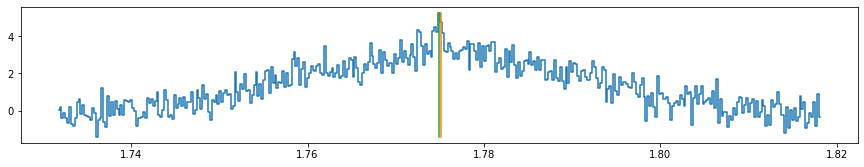

In [11]:
## Let us have a look
toshow = 1
offset = 400
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    plt.plot(wfreq[i+offset],wflux[i+offset],drawstyle='steps-mid')
    plt.plot([wfreq[i+offset,int(wpos_tr[i+offset])],wfreq[i+offset,int(wpos_tr[i+offset])]],[np.min(wflux[i+offset]),np.max(wflux[i+offset])])
    plt.plot([wfreq[i+offset,int(wpos_gs[i+offset])],wfreq[i+offset,int(wpos_gs[i+offset])]],[np.min(wflux[i+offset]),np.max(wflux[i+offset])])

plt.show()

# Do the thing: Use NN to try to guess z

In [12]:
## Split data into training and evaluation

NN = len(wfreq)
train_frac = 0.8
train_N = int(train_frac * NN)
print(train_N)

## Define test and training data

trainx = wflux[0:train_N]
trainy = wpos_tr[0:train_N]

testx  = wflux[train_N:]
testy  = wpos_tr[train_N:]

80000


In [60]:
## Define Neural networks and compare

model_001a = Sequential()
model_001a.add(Dense(400, input_dim=(2*window+1), activation='relu',kernel_initializer='he_normal'))
model_001a.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001a.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001a.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001a.add(Dense(20, activation='relu',kernel_initializer='he_normal'))
model_001a.add(Dense(1))
model_001a.compile(loss='mean_squared_error', optimizer='adam')

model_001b = Sequential()
model_001b.add(Dense(400, input_dim=(2*window+1), activation='relu',kernel_initializer='he_normal'))
model_001b.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001b.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001b.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001b.add(Dense(20, activation='relu',kernel_initializer='he_normal'))
model_001b.add(Dense(1))
model_001b.compile(loss='mean_squared_error', optimizer='adam')

model_001c = Sequential()
model_001c.add(Dense(400, input_dim=(2*window+1), activation='relu',kernel_initializer='he_normal'))
model_001c.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001c.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001c.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001c.add(Dense(20, activation='relu',kernel_initializer='he_normal'))
model_001c.add(Dense(1))
model_001c.compile(loss='mean_squared_error', optimizer='adam')

model_001d = Sequential()
model_001d.add(Dense(400, input_dim=(2*window+1), activation='relu',kernel_initializer='he_normal'))
model_001d.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001d.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001d.add(Dense(400, activation='relu',kernel_initializer='he_normal'))
model_001d.add(Dense(20, activation='relu',kernel_initializer='he_normal'))
model_001d.add(Dense(1))
model_001d.compile(loss='mean_squared_error', optimizer='adam')

In [61]:
model_002a = Sequential()
model_002a.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_002a.add(Dense(400, activation='relu'))
model_002a.add(Dense(400, activation='relu'))
model_002a.add(Dense(20, activation='relu'))
model_002a.add(Dense(1))
model_002a.compile(loss='mean_squared_error', optimizer='adam')

model_002b = Sequential()
model_002b.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_002b.add(Dense(400, activation='relu'))
model_002b.add(Dense(400, activation='relu'))
model_002b.add(Dense(20, activation='relu'))
model_002b.add(Dense(1))
model_002b.compile(loss='mean_squared_error', optimizer='adam')

model_002c = Sequential()
model_002c.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_002c.add(Dense(400, activation='relu'))
model_002c.add(Dense(400, activation='relu'))
model_002c.add(Dense(20, activation='relu'))
model_002c.add(Dense(1))
model_002c.compile(loss='mean_squared_error', optimizer='adam')

model_002d = Sequential()
model_002d.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_002d.add(Dense(400, activation='relu'))
model_002d.add(Dense(400, activation='relu'))
model_002d.add(Dense(20, activation='relu'))
model_002d.add(Dense(1))
model_002d.compile(loss='mean_squared_error', optimizer='adam')

In [63]:
model_003a = Sequential()
model_003a.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_003a.add(Dense(400, activation='relu'))
model_003a.add(Dense(20, activation='relu'))
model_003a.add(Dense(1))
model_003a.compile(loss='mean_squared_error', optimizer='adam')

model_003b = Sequential()
model_003b.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_003b.add(Dense(400, activation='relu'))
model_003b.add(Dense(20, activation='relu'))
model_003b.add(Dense(1))
model_003b.compile(loss='mean_squared_error', optimizer='adam')

model_003c = Sequential()
model_003c.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_003c.add(Dense(400, activation='relu'))
model_003c.add(Dense(20, activation='relu'))
model_003c.add(Dense(1))
model_003c.compile(loss='mean_squared_error', optimizer='adam')

model_003d = Sequential()
model_003d.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_003d.add(Dense(400, activation='relu'))
model_003d.add(Dense(20, activation='relu'))
model_003d.add(Dense(1))
model_003d.compile(loss='mean_squared_error', optimizer='adam')


In [64]:
model_004a = Sequential()
model_004a.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_004a.add(Dense(400, activation='relu'))
model_004a.add(Dense(400, activation='relu'))
model_004a.add(Dense(400, activation='relu'))
model_004a.add(Dense(20, activation='relu'))
model_004a.add(Dense(1))
model_004a.compile(loss='mean_squared_error', optimizer='adam')

model_004b = Sequential()
model_004b.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_004b.add(Dense(400, activation='relu'))
model_004b.add(Dense(400, activation='relu'))
model_004b.add(Dense(400, activation='relu'))
model_004b.add(Dense(20, activation='relu'))
model_004b.add(Dense(1))
model_004b.compile(loss='mean_squared_error', optimizer='adam')

model_004c = Sequential()
model_004c.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_004c.add(Dense(400, activation='relu'))
model_004c.add(Dense(400, activation='relu'))
model_004c.add(Dense(400, activation='relu'))
model_004c.add(Dense(20, activation='relu'))
model_004c.add(Dense(1))
model_004c.compile(loss='mean_squared_error', optimizer='adam')

model_004d = Sequential()
model_004d.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_004d.add(Dense(400, activation='relu'))
model_004d.add(Dense(400, activation='relu'))
model_004d.add(Dense(400, activation='relu'))
model_004d.add(Dense(20, activation='relu'))
model_004d.add(Dense(1))
model_004d.compile(loss='mean_squared_error', optimizer='adam')


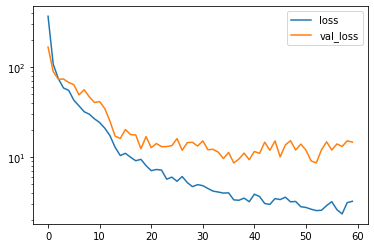

done with 001


In [65]:
## Run the damned training sessions

history_001a = model_001a.fit(trainx, trainy, epochs=100, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])

history_001b = model_001b.fit(trainx, trainy, epochs=100, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])

history_001c = model_001c.fit(trainx, trainy, epochs=60, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])

history_001d = model_001d.fit(trainx, trainy, epochs=60, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
print("done with 001")

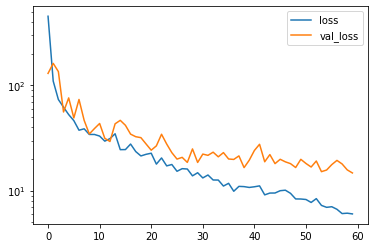

done with 002


In [66]:
history_002a = model_002a.fit(trainx, trainy, epochs=100, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_002b = model_002b.fit(trainx, trainy, epochs=100, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_002c = model_002c.fit(trainx, trainy, epochs=60, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_002d = model_002d.fit(trainx, trainy, epochs=60, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
print("done with 002")

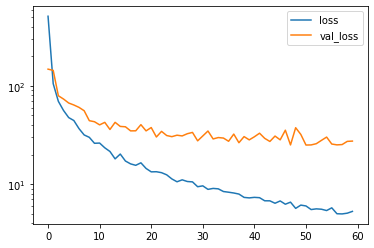

done with 003


In [67]:
history_003a = model_003a.fit(trainx, trainy, epochs=100, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_003b = model_003b.fit(trainx, trainy, epochs=100, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_003c = model_003c.fit(trainx, trainy, epochs=60, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_003d = model_003d.fit(trainx, trainy, epochs=60, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])

print("done with 003")

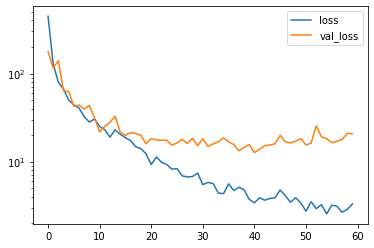

done with 003


In [68]:
history_004a = model_004a.fit(trainx, trainy, epochs=100, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_004b = model_004b.fit(trainx, trainy, epochs=100, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_004c = model_004c.fit(trainx, trainy, epochs=60, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])
history_004d = model_004d.fit(trainx, trainy, epochs=60, verbose=1, shuffle=True,\
                            validation_split=0.1,callbacks=[plot_losses])

print("done with 003")

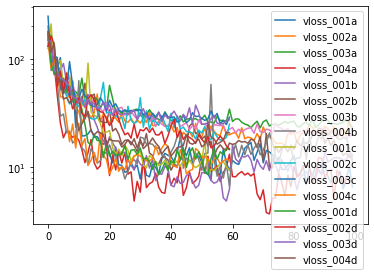

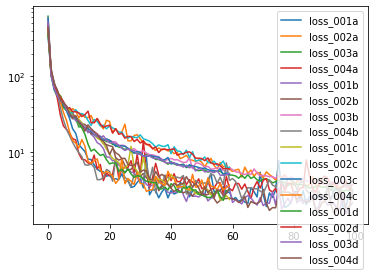

In [70]:
## Shows the history of convergence...

plt.plot(history_001a.history['val_loss'],label='vloss_001a')
plt.plot(history_002a.history['val_loss'],label='vloss_002a')
plt.plot(history_003a.history['val_loss'],label='vloss_003a')
plt.plot(history_004a.history['val_loss'],label='vloss_004a')

plt.yscale('log')
plt.plot(history_001b.history['val_loss'],label='vloss_001b')
plt.plot(history_002b.history['val_loss'],label='vloss_002b')
plt.plot(history_003b.history['val_loss'],label='vloss_003b')
plt.plot(history_004b.history['val_loss'],label='vloss_004b')

plt.plot(history_001c.history['val_loss'],label='vloss_001c')
plt.plot(history_002c.history['val_loss'],label='vloss_002c')
plt.plot(history_003c.history['val_loss'],label='vloss_003c')
plt.plot(history_004c.history['val_loss'],label='vloss_004c')

plt.plot(history_001d.history['val_loss'],label='vloss_001d')
plt.plot(history_002d.history['val_loss'],label='vloss_002d')
plt.plot(history_003d.history['val_loss'],label='vloss_003d')
plt.plot(history_004d.history['val_loss'],label='vloss_004d')
plt.legend()
plt.show()

plt.plot(history_001a.history['loss'],label='loss_001a')
plt.plot(history_002a.history['loss'],label='loss_002a')
plt.plot(history_003a.history['loss'],label='loss_003a')
plt.plot(history_004a.history['loss'],label='loss_004a')

plt.yscale('log')
plt.plot(history_001b.history['loss'],label='loss_001b')
plt.plot(history_002b.history['loss'],label='loss_002b')
plt.plot(history_003b.history['loss'],label='loss_003b')
plt.plot(history_004b.history['loss'],label='loss_004b')

plt.plot(history_001c.history['loss'],label='loss_001c')
plt.plot(history_002c.history['loss'],label='loss_002c')
plt.plot(history_003c.history['loss'],label='loss_003c')
plt.plot(history_004c.history['loss'],label='loss_004c')

plt.plot(history_001d.history['loss'],label='loss_001d')
plt.plot(history_002d.history['loss'],label='loss_002d')
plt.plot(history_003d.history['loss'],label='loss_003d')
plt.plot(history_004d.history['loss'],label='loss_004d')
plt.legend()
plt.show()

In [71]:
## Used the neural network to make predictions

predict_001a = model_001a.predict(wflux)[:,0]
predict_002a = model_002a.predict(wflux)[:,0]
predict_003a = model_003a.predict(wflux)[:,0]
predict_004a = model_004a.predict(wflux)[:,0]

predict_001b = model_001b.predict(wflux)[:,0]
predict_002b = model_002b.predict(wflux)[:,0]
predict_003b = model_003b.predict(wflux)[:,0]
predict_004b = model_004b.predict(wflux)[:,0]

predict_001c = model_001c.predict(wflux)[:,0]
predict_002c = model_002c.predict(wflux)[:,0]
predict_003c = model_003c.predict(wflux)[:,0]
predict_004c = model_004c.predict(wflux)[:,0]

predict_001d = model_001d.predict(wflux)[:,0]
predict_002d = model_002d.predict(wflux)[:,0]
predict_003d = model_003d.predict(wflux)[:,0]
predict_004d = model_004d.predict(wflux)[:,0]

In [72]:
pred_opzs_001a = con_pos2opz(wshift+predict_001a,freq[:,0],freq[:,-1],2048)
pred_opzs_002a = con_pos2opz(wshift+predict_002a,freq[:,0],freq[:,-1],2048)
pred_opzs_003a = con_pos2opz(wshift+predict_003a,freq[:,0],freq[:,-1],2048)
pred_opzs_004a = con_pos2opz(wshift+predict_004a,freq[:,0],freq[:,-1],2048)

pred_opzs_001b = con_pos2opz(wshift+predict_001b,freq[:,0],freq[:,-1],2048)
pred_opzs_002b = con_pos2opz(wshift+predict_002b,freq[:,0],freq[:,-1],2048)
pred_opzs_003b = con_pos2opz(wshift+predict_003b,freq[:,0],freq[:,-1],2048)
pred_opzs_004b = con_pos2opz(wshift+predict_004b,freq[:,0],freq[:,-1],2048)

pred_opzs_001c = con_pos2opz(wshift+predict_001c,freq[:,0],freq[:,-1],2048)
pred_opzs_002c = con_pos2opz(wshift+predict_002c,freq[:,0],freq[:,-1],2048)
pred_opzs_003c = con_pos2opz(wshift+predict_003c,freq[:,0],freq[:,-1],2048)
pred_opzs_004c = con_pos2opz(wshift+predict_004c,freq[:,0],freq[:,-1],2048)

pred_opzs_001d = con_pos2opz(wshift+predict_001d,freq[:,0],freq[:,-1],2048)
pred_opzs_002d = con_pos2opz(wshift+predict_002d,freq[:,0],freq[:,-1],2048)
pred_opzs_003d = con_pos2opz(wshift+predict_003d,freq[:,0],freq[:,-1],2048)
pred_opzs_004d = con_pos2opz(wshift+predict_004d,freq[:,0],freq[:,-1],2048)

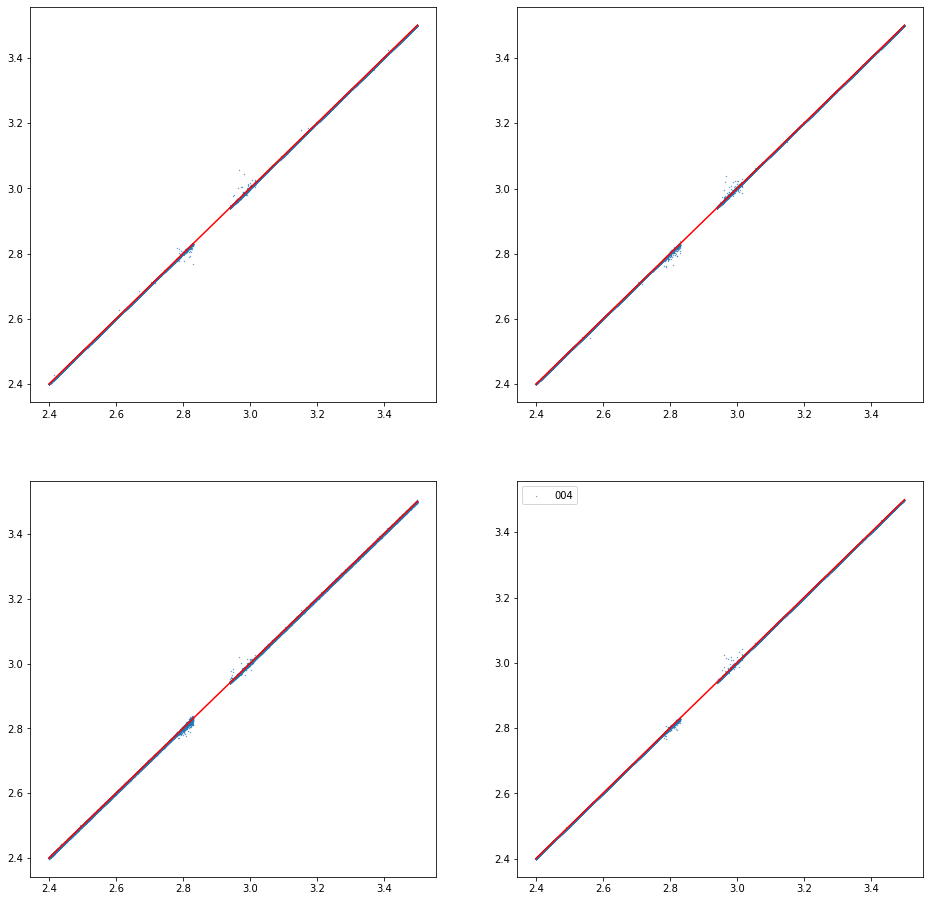

In [73]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.scatter(opzs[train_N:],pred_opzs_001a[train_N:],s=0.1,label='001')
plt.plot([2.4,3.5],[2.4,3.5],'r-')
plt.subplot(2,2,2)
plt.scatter(opzs[train_N:],pred_opzs_002a[train_N:],s=0.1,label='002')
plt.plot([2.4,3.5],[2.4,3.5],'r-')
plt.subplot(2,2,3)
plt.scatter(opzs[train_N:],pred_opzs_003a[train_N:],s=0.1,label='003')
plt.plot([2.4,3.5],[2.4,3.5],'r-')
plt.subplot(2,2,4)
plt.scatter(opzs[train_N:],pred_opzs_004a[train_N:],s=0.1,label='004')
plt.plot([2.4,3.5],[2.4,3.5],'r-')
plt.legend()

plt.show()

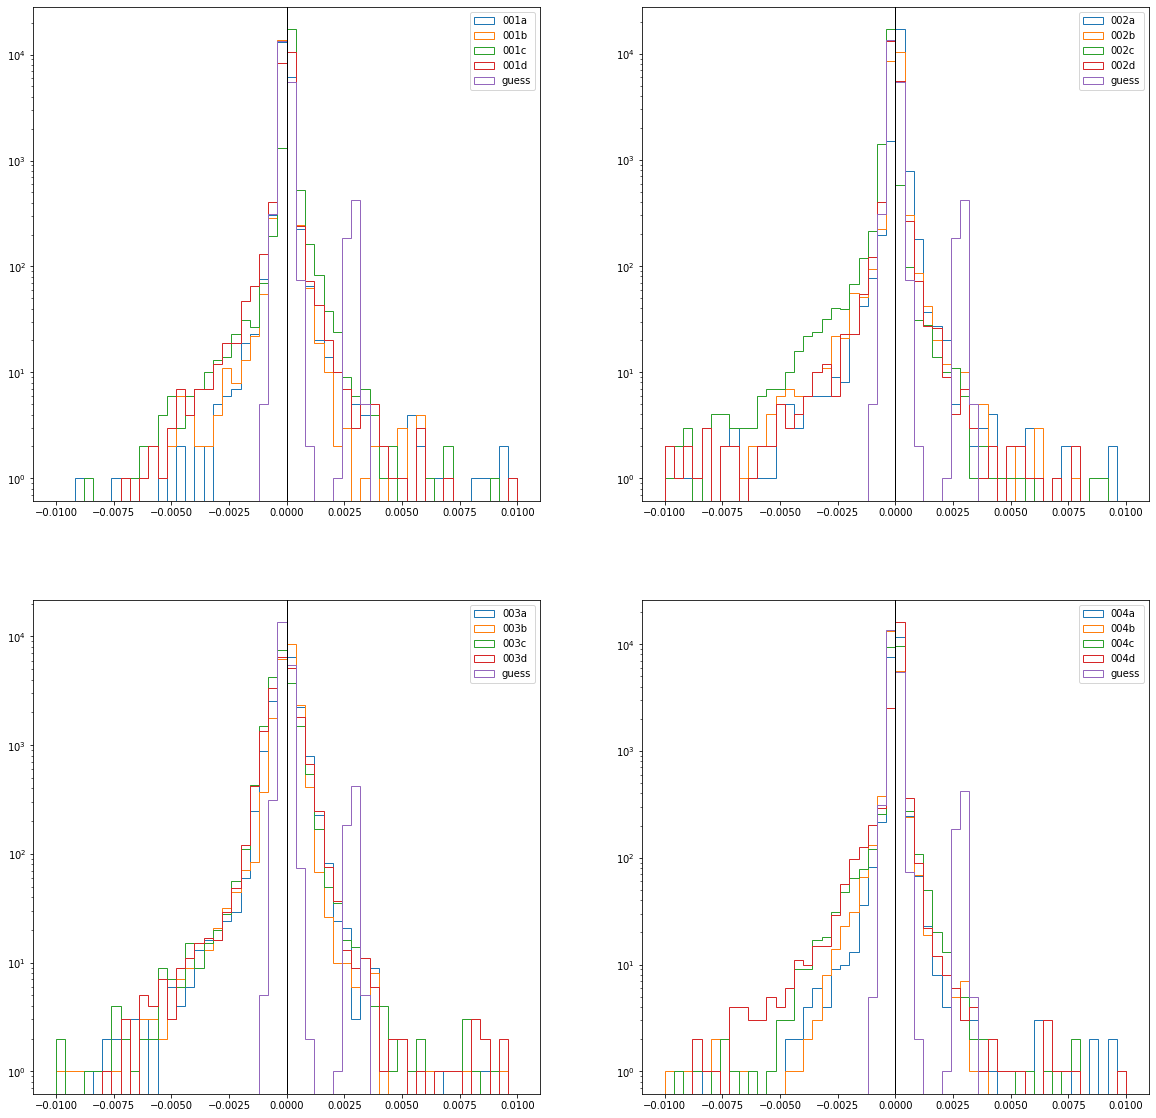

20000.0
19996.0


In [84]:
mybins=np.linspace(-0.01,0.01,51)

acc_001a = (pred_opzs_001a[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_002a = (pred_opzs_002a[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_003a = (pred_opzs_003a[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_004a = (pred_opzs_004a[train_N:]-opzs[train_N:])/opzs[train_N:]

acc_001b = (pred_opzs_001b[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_002b = (pred_opzs_002b[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_003b = (pred_opzs_003b[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_004b = (pred_opzs_004b[train_N:]-opzs[train_N:])/opzs[train_N:]

acc_001c = (pred_opzs_001c[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_002c = (pred_opzs_002c[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_003c = (pred_opzs_003c[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_004c = (pred_opzs_004c[train_N:]-opzs[train_N:])/opzs[train_N:]

acc_001d = (pred_opzs_001d[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_002d = (pred_opzs_002d[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_003d = (pred_opzs_003d[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_004d = (pred_opzs_004d[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_guess = (opz_guess7[train_N:]-opzs[train_N:])/opzs[train_N:]

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
k1 = plt.hist(acc_001a,bins=mybins,histtype='step',label='001a')
k2 = plt.hist(acc_001b,bins=mybins,histtype='step',label='001b')
k3 = plt.hist(acc_001c,bins=mybins,histtype='step',label='001c')
k4 = plt.hist(acc_001d,bins=mybins,histtype='step',label='001d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

plt.subplot(2,2,2)
k1 = plt.hist(acc_002a,bins=mybins,histtype='step',label='002a')
k2 = plt.hist(acc_002b,bins=mybins,histtype='step',label='002b')
k3 = plt.hist(acc_002c,bins=mybins,histtype='step',label='002c')
k4 = plt.hist(acc_002d,bins=mybins,histtype='step',label='002d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

plt.subplot(2,2,3)
k1 = plt.hist(acc_003a,bins=mybins,histtype='step',label='003a')
k2 = plt.hist(acc_003b,bins=mybins,histtype='step',label='003b')
k3 = plt.hist(acc_003c,bins=mybins,histtype='step',label='003c')
k4 = plt.hist(acc_003d,bins=mybins,histtype='step',label='003d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

plt.subplot(2,2,4)
k1 = plt.hist(acc_004a,bins=mybins,histtype='step',label='004a')
k2 = plt.hist(acc_004b,bins=mybins,histtype='step',label='004b')
k3 = plt.hist(acc_004c,bins=mybins,histtype='step',label='004c')
k4 = plt.hist(acc_004d,bins=mybins,histtype='step',label='004d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')


plt.show()

print(np.sum(k5[0]))
print(np.sum(k1[0]))

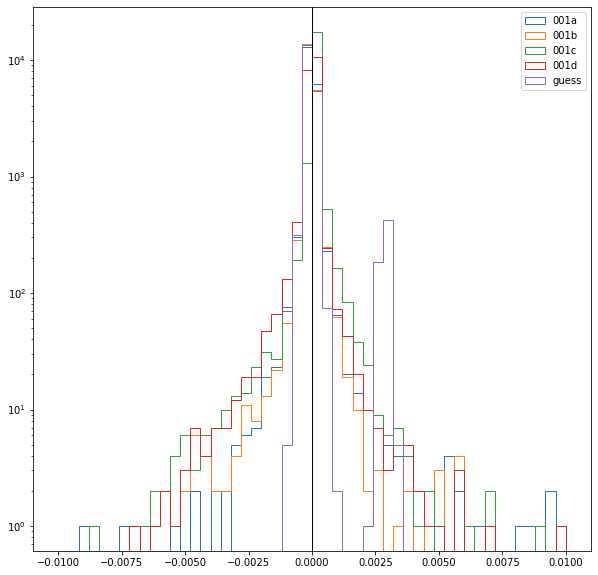

20000.0
19992.0


In [89]:
mybins=np.linspace(-0.01,0.01,51)

plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
k1 = plt.hist(acc_001a,bins=mybins,histtype='step',label='001a')
k2 = plt.hist(acc_001b,bins=mybins,histtype='step',label='001b')
k3 = plt.hist(acc_001c,bins=mybins,histtype='step',label='001c')
k4 = plt.hist(acc_001d,bins=mybins,histtype='step',label='001d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

#plt.subplot(2,2,2)
#k1 = plt.hist(acc_002a,bins=mybins,histtype='step',label='002a')
#k2 = plt.hist(acc_002b,bins=mybins,histtype='step',label='002b')
#k3 = plt.hist(acc_002c,bins=mybins,histtype='step',label='002c')
#k4 = plt.hist(acc_002d,bins=mybins,histtype='step',label='002d')
#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
#plt.axvline(0,linewidth=1, color='k')
#plt.legend()
#plt.yscale('log')

#plt.subplot(2,2,3)
#k1 = plt.hist(acc_003a,bins=mybins,histtype='step',label='003a')
#k2 = plt.hist(acc_003b,bins=mybins,histtype='step',label='003b')
#k3 = plt.hist(acc_003c,bins=mybins,histtype='step',label='003c')
#k4 = plt.hist(acc_003d,bins=mybins,histtype='step',label='003d')
#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
#plt.axvline(0,linewidth=1, color='k')
#plt.legend()
#plt.yscale('log')

#plt.subplot(2,2,4)
#k1 = plt.hist(acc_004a,bins=mybins,histtype='step',label='004a')
#k2 = plt.hist(acc_004b,bins=mybins,histtype='step',label='004b')
#k3 = plt.hist(acc_004c,bins=mybins,histtype='step',label='004c')
#k4 = plt.hist(acc_004d,bins=mybins,histtype='step',label='004d')
#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
#plt.axvline(0,linewidth=1, color='k')
#plt.legend()
#plt.yscale('log')

#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')


plt.show()

print(np.sum(k5[0]))
print(np.sum(k1[0]))

In [125]:
v1 = (pred_opzs_001a[train_N:])/opzs[train_N:]
v2 = (pred_opzs_001b[train_N:])/opzs[train_N:]
v3 = (pred_opzs_001c[train_N:])/opzs[train_N:]
v4 = (pred_opzs_001d[train_N:])/opzs[train_N:]

In [155]:
v1sq = np.sum(v1**2)
v2sq = np.sum(v2**2)
v3sq = np.sum(v3**2)
v4sq = np.sum(v4**2)

v1v2 = np.sum(v1*v2)
v1v3 = np.sum(v1*v3)
v1v4 = np.sum(v1*v4)
v2v3 = np.sum(v2*v3)
v2v4 = np.sum(v2*v4)
v3v4 = np.sum(v3*v4)

mat = [[v1sq,v1v2,v1v3,v1v4],[v1v2,v2sq,v2v3,v2v4],[v1v3,v2v3,v3sq,v3v4],[v1v4,v2v4,v3v4,v4sq]]

sv1 = np.sum(v1)
sv2 = np.sum(v2)
sv3 = np.sum(v3)
sv4 = np.sum(v4)

In [156]:
print(np.matrix(mat))

[[19999.07969672 19998.79947609 20002.2515214  19999.26614901]
 [19998.79947609 19998.52334319 20001.97357285 19998.98845927]
 [20002.2515214  20001.97357285 20005.42818231 20002.44098333]
 [19999.26614901 19998.98845927 20002.44098333 19999.45668873]]


In [157]:
print(np.linalg.det(mat))
res = np.dot(np.linalg.inv(mat),np.array([sv1,sv2,sv3,sv4]))
print(res)
print(np.sum(res))


0.00042545695849748657
[0.11242786 0.48070702 0.04294369 0.36394086]
1.0000194339081645


In [158]:
better = res[0]*pred_opzs_001a[train_N:]+res[1]*pred_opzs_001b[train_N:]+res[3]*pred_opzs_001d[train_N:]+res[2]*pred_opzs_001c[train_N:]

In [159]:
acc_better = (better-opzs[train_N:])/opzs[train_N:]

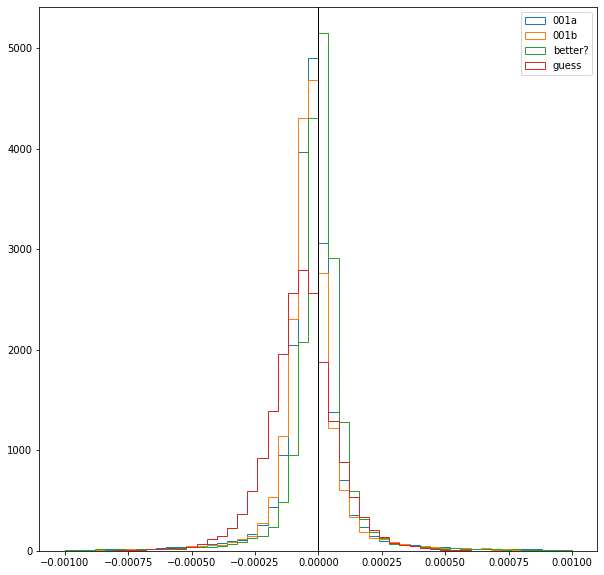

19388.0
19811.0


In [164]:
mybins=np.linspace(-0.001,0.001,51)

plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
k1 = plt.hist(acc_001a,bins=mybins,histtype='step',label='001a')
k2 = plt.hist(acc_001b,bins=mybins,histtype='step',label='001b')
k3 = plt.hist(acc_better,bins=mybins,histtype='step',label='better?')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
#plt.yscale('log')

#plt.subplot(2,2,2)
#k1 = plt.hist(acc_002a,bins=mybins,histtype='step',label='002a')
#k2 = plt.hist(acc_002b,bins=mybins,histtype='step',label='002b')
#k3 = plt.hist(acc_002c,bins=mybins,histtype='step',label='002c')
#k4 = plt.hist(acc_002d,bins=mybins,histtype='step',label='002d')
#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
#plt.axvline(0,linewidth=1, color='k')
#plt.legend()
#plt.yscale('log')

#plt.subplot(2,2,3)
#k1 = plt.hist(acc_003a,bins=mybins,histtype='step',label='003a')
#k2 = plt.hist(acc_003b,bins=mybins,histtype='step',label='003b')
#k3 = plt.hist(acc_003c,bins=mybins,histtype='step',label='003c')
#k4 = plt.hist(acc_003d,bins=mybins,histtype='step',label='003d')
#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
#plt.axvline(0,linewidth=1, color='k')
#plt.legend()
#plt.yscale('log')

#plt.subplot(2,2,4)
#k1 = plt.hist(acc_004a,bins=mybins,histtype='step',label='004a')
#k2 = plt.hist(acc_004b,bins=mybins,histtype='step',label='004b')
#k3 = plt.hist(acc_004c,bins=mybins,histtype='step',label='004c')
#k4 = plt.hist(acc_004d,bins=mybins,histtype='step',label='004d')
#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
#plt.axvline(0,linewidth=1, color='k')
#plt.legend()
#plt.yscale('log')

#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')


plt.show()

print(np.sum(k5[0]))
print(np.sum(k1[0]))

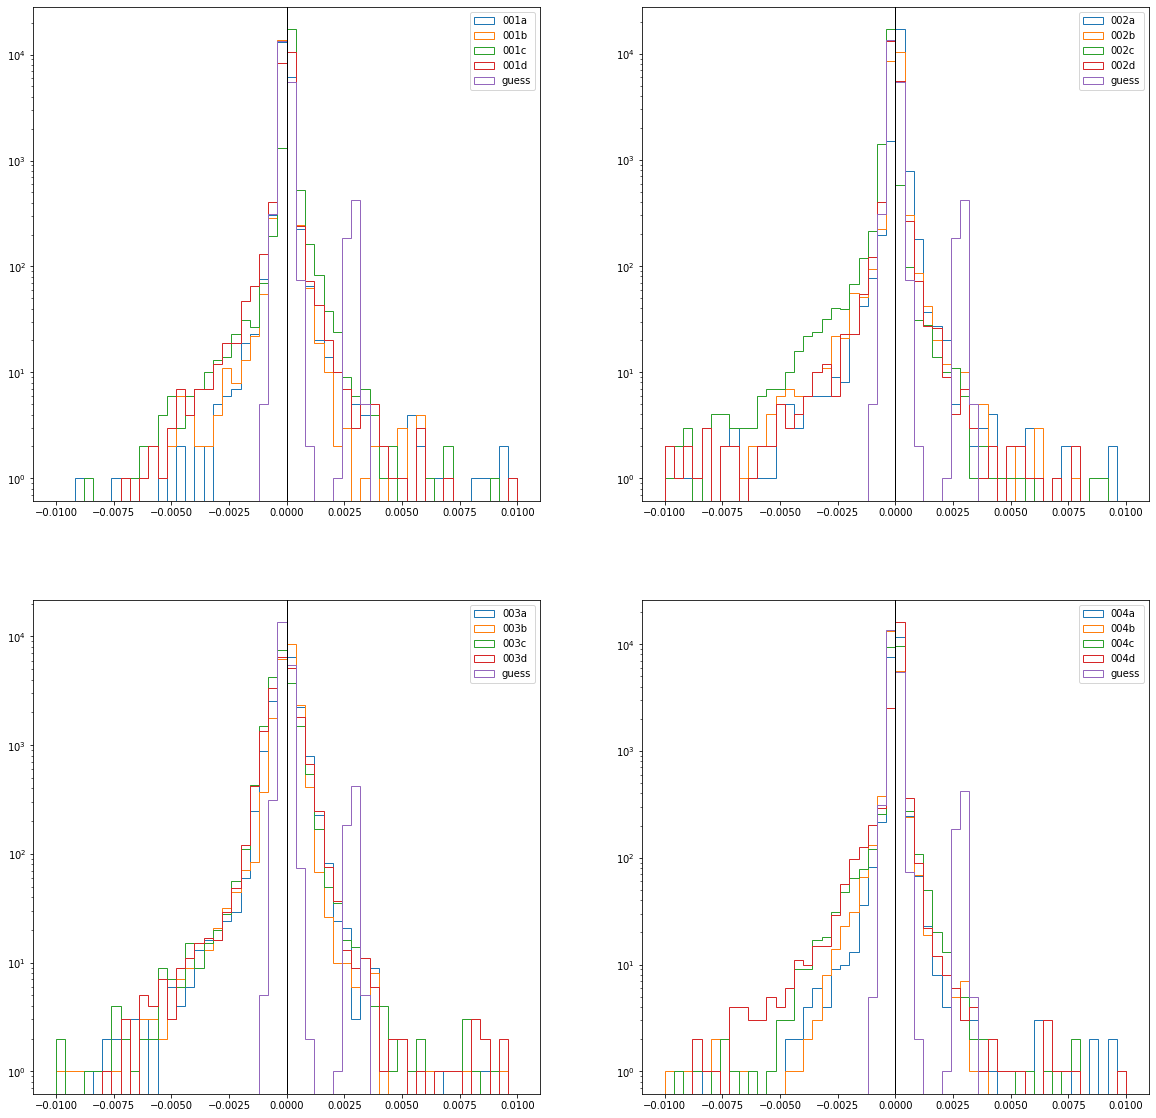

20000.0
19996.0


In [152]:
mybins=np.linspace(-0.01,0.01,51)

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
k1 = plt.hist(acc_001a,bins=mybins,histtype='step',label='001a')
k2 = plt.hist(acc_001b,bins=mybins,histtype='step',label='001b')
k3 = plt.hist(acc_001c,bins=mybins,histtype='step',label='001c')
k4 = plt.hist(acc_001d,bins=mybins,histtype='step',label='001d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

plt.subplot(2,2,2)
k1 = plt.hist(acc_002a,bins=mybins,histtype='step',label='002a')
k2 = plt.hist(acc_002b,bins=mybins,histtype='step',label='002b')
k3 = plt.hist(acc_002c,bins=mybins,histtype='step',label='002c')
k4 = plt.hist(acc_002d,bins=mybins,histtype='step',label='002d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

plt.subplot(2,2,3)
k1 = plt.hist(acc_003a,bins=mybins,histtype='step',label='003a')
k2 = plt.hist(acc_003b,bins=mybins,histtype='step',label='003b')
k3 = plt.hist(acc_003c,bins=mybins,histtype='step',label='003c')
k4 = plt.hist(acc_003d,bins=mybins,histtype='step',label='003d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

plt.subplot(2,2,4)
k1 = plt.hist(acc_004a,bins=mybins,histtype='step',label='004a')
k2 = plt.hist(acc_004b,bins=mybins,histtype='step',label='004b')
k3 = plt.hist(acc_004c,bins=mybins,histtype='step',label='004c')
k4 = plt.hist(acc_004d,bins=mybins,histtype='step',label='004d')
k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.yscale('log')

#k5 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')


plt.show()

print(np.sum(k5[0]))
print(np.sum(k1[0]))

In [85]:
print("001a", np.percentile(acc_001a,50))
print("002a", np.percentile(acc_002a,50))
print("003a", np.percentile(acc_003a,50))
print("004a", np.percentile(acc_004a,50))
print()
print("001b", np.percentile(acc_001b,50))
print("002b", np.percentile(acc_002b,50))
print("003b", np.percentile(acc_003b,50))
print("004b", np.percentile(acc_004b,50))
print()
print("001c", np.percentile(acc_001c,50))
print("002c", np.percentile(acc_002c,50))
print("003c", np.percentile(acc_003c,50))
print("004c", np.percentile(acc_004c,50))
print()
print("001d", np.percentile(acc_001d,50))
print("002d", np.percentile(acc_002d,50))
print("003d", np.percentile(acc_003d,50))
print("004d", np.percentile(acc_004d,50))
print()


001a -2.8521028610029097e-05
002a 0.0001527259700729299
003a -3.227303483533739e-06
004a 1.6999338509153303e-05

001b -3.524894273174618e-05
002b 7.059072001370746e-06
003b 4.9508047099646666e-05
004b -3.6240428341092405e-05

001c 0.0001400077606551645
002c -0.00024094988383051324
003c -0.0002214416415065296
004c 3.0748500207817874e-07

001d 7.807931467374103e-06
002d -4.4943784504621557e-05
003d -0.00010544702694090377
004d 8.090043315977345e-05


In [161]:
print("001a", np.percentile(acc_001a,50))
print("001b", np.percentile(acc_001b,50))
print("001c", np.percentile(acc_001c,50))
print("001d", np.percentile(acc_001d,50))
print()
print("better?: ",np.percentile(acc_better,50))
print()
print("002a", np.percentile(acc_002a,50))
print("002b", np.percentile(acc_002b,50))
print("002c", np.percentile(acc_002c,50))
print("002d", np.percentile(acc_002d,50))
print()
print("003a", np.percentile(acc_003a,50))
print("003b", np.percentile(acc_003b,50))
print("003c", np.percentile(acc_003c,50))
print("003d", np.percentile(acc_003d,50))
print()
print("004a", np.percentile(acc_004a,50))
print("004b", np.percentile(acc_004b,50))
print("004c", np.percentile(acc_004c,50))
print("004d", np.percentile(acc_004d,50))

001a -2.8521028610029097e-05
001b -3.524894273174618e-05
001c 0.0001400077606551645
001d 7.807931467374103e-06

better?:  7.4010012277007e-06

002a 0.0001527259700729299
002b 7.059072001370746e-06
002c -0.00024094988383051324
002d -4.4943784504621557e-05

003a -3.227303483533739e-06
003b 4.9508047099646666e-05
003c -0.0002214416415065296
003d -0.00010544702694090377

004a 1.6999338509153303e-05
004b -3.6240428341092405e-05
004c 3.0748500207817874e-07
004d 8.090043315977345e-05


In [162]:
print("001a", (np.percentile(acc_001a,84)-np.percentile(acc_001a,16))/2)
print("002a", (np.percentile(acc_002a,84)-np.percentile(acc_002a,16))/2)
print("003a", (np.percentile(acc_003a,84)-np.percentile(acc_003a,16))/2)
print("004a", (np.percentile(acc_004a,84)-np.percentile(acc_004a,16))/2)
print()
print("better?: ", (np.percentile(acc_better,84)-np.percentile(acc_better,16))/2)
print()
print("001b", (np.percentile(acc_001b,84)-np.percentile(acc_001b,16))/2)
print("002b", (np.percentile(acc_002b,84)-np.percentile(acc_002b,16))/2)
print("003b", (np.percentile(acc_003b,84)-np.percentile(acc_003b,16))/2)
print("004b", (np.percentile(acc_004b,84)-np.percentile(acc_004b,16))/2)
print()
print("001c", (np.percentile(acc_001c,84)-np.percentile(acc_001c,16))/2)
print("002c", (np.percentile(acc_002c,84)-np.percentile(acc_002c,16))/2)
print("003c", (np.percentile(acc_003c,84)-np.percentile(acc_003c,16))/2)
print("004c", (np.percentile(acc_004c,84)-np.percentile(acc_004c,16))/2)
print()
print("001d", (np.percentile(acc_001d,84)-np.percentile(acc_001d,16))/2)
print("002d", (np.percentile(acc_002d,84)-np.percentile(acc_002d,16))/2)
print("003d", (np.percentile(acc_003d,84)-np.percentile(acc_003d,16))/2)
print("004d", (np.percentile(acc_004d,84)-np.percentile(acc_004d,16))/2)

001a 7.439752447823477e-05
002a 9.47921643754979e-05
003a 0.00045081270233734755
004a 7.560002198395389e-05

better?:  6.966786513506527e-05

001b 7.453433146590125e-05
002b 7.709811397491306e-05
003b 0.00034738628702950356
004b 8.476642081532587e-05

001c 8.203167887283058e-05
002c 9.509750675698128e-05
003c 0.00047181108107130954
004c 8.541931997081099e-05

001d 7.972961324333457e-05
002d 9.34194714141646e-05
003d 0.0004931916125886311
004d 8.370271496905314e-05


In [86]:
print("001a", (np.percentile(acc_001a,84)-np.percentile(acc_001a,16))/2)
print("001b", (np.percentile(acc_001b,84)-np.percentile(acc_001b,16))/2)
print("001c", (np.percentile(acc_001c,84)-np.percentile(acc_001c,16))/2)
print("001d", (np.percentile(acc_001d,84)-np.percentile(acc_001d,16))/2)
print()
print("002a", (np.percentile(acc_002a,84)-np.percentile(acc_002a,16))/2)
print("002b", (np.percentile(acc_002b,84)-np.percentile(acc_002b,16))/2)
print("002c", (np.percentile(acc_002c,84)-np.percentile(acc_002c,16))/2)
print("002d", (np.percentile(acc_002d,84)-np.percentile(acc_002d,16))/2)
print()
print("003a", (np.percentile(acc_003a,84)-np.percentile(acc_003a,16))/2)
print("003b", (np.percentile(acc_003b,84)-np.percentile(acc_003b,16))/2)
print("003c", (np.percentile(acc_003c,84)-np.percentile(acc_003c,16))/2)
print("003d", (np.percentile(acc_003d,84)-np.percentile(acc_003d,16))/2)
print()
print("004a", (np.percentile(acc_004a,84)-np.percentile(acc_004a,16))/2)
print("004b", (np.percentile(acc_004b,84)-np.percentile(acc_004b,16))/2)
print("004c", (np.percentile(acc_004c,84)-np.percentile(acc_004c,16))/2)
print("004d", (np.percentile(acc_004d,84)-np.percentile(acc_004d,16))/2)

001a 7.439752447823477e-05
001b 7.453433146590125e-05
001c 8.203167887283058e-05
001d 7.972961324333457e-05

002a 9.47921643754979e-05
002b 7.709811397491306e-05
002c 9.509750675698128e-05
002d 9.34194714141646e-05

003a 0.00045081270233734755
003b 0.00034738628702950356
003c 0.00047181108107130954
003d 0.0004931916125886311

004a 7.560002198395389e-05
004b 8.476642081532587e-05
004c 8.541931997081099e-05
004d 8.370271496905314e-05


In [35]:
bounds = np.logspace(-7,0,51)
within_001 = np.zeros_like(bounds)
within_002 = np.zeros_like(bounds)
within_003 = np.zeros_like(bounds)
within_004 = np.zeros_like(bounds)

for i,k in enumerate(bounds):
    within_001[i] = np.sum( ((-k<acc_001) & (acc_001<k))*1.0)/len(acc_001)
    within_002[i] = np.sum( ((-k<acc_002) & (acc_002<k))*1.0)/len(acc_002)
    within_003[i] = np.sum( ((-k<acc_003) & (acc_003<k))*1.0)/len(acc_003)
    within_003[i] = np.sum( ((-k<acc_004) & (acc_003<k))*1.0)/len(acc_004)

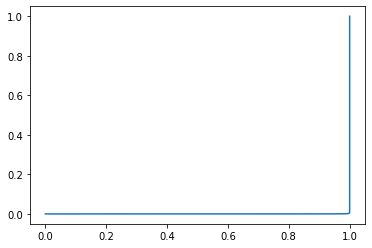

In [450]:
#plt.loglog(within_001,bounds)
plt.plot(  within_002,bounds)
#plt.plot(  within_003,bounds)
plt.show()